In [101]:
import arrow as A
import scipy
from PIL import Image
import torch
import torchmetrics
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import itertools
import torchvision
import xarray as xr

In [2]:
torch.cuda.empty_cache()
print(f'( {torch.cuda.device_count()} ) {torch.cuda.get_device_name(0)} available')

( 1 ) NVIDIA GeForce GTX 1080 Ti available


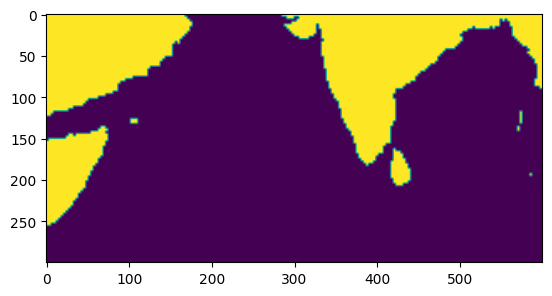

In [3]:
def xarr2torch(x):
        return torch.from_numpy(np.asarray(x)).unsqueeze(0).unsqueeze(0).float()

land_mask = xr.open_dataset('../data/land_mask.nc')
land_mask = land_mask.GLDAS_mask[0][800:1100,2700:3300]
land_mask = xarr2torch(land_mask)
plt.imshow(land_mask[0,0])

In [4]:
patchsize=100
unfoldobj = torch.nn.Unfold(kernel_size = (patchsize,patchsize),stride=int((patchsize/1)))
mask_patches = unfoldobj(land_mask).permute(2,0,1).reshape(-1,1,patchsize,patchsize)
mask_patches.shape

torch.Size([18, 1, 100, 100])

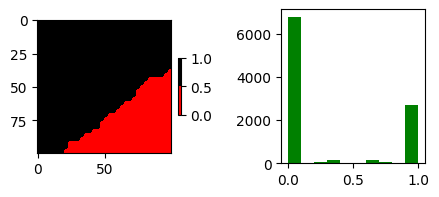

In [24]:
blackRed = matplotlib.colors.ListedColormap(['red','black'])



fig = plt.figure(figsize=(5,2))
gs = gridspec.GridSpec(1,2,wspace=.7)


fig.add_subplot(gs[0,0])
plt.imshow(mask_patches[4,0],cmap=blackRed)
plt.colorbar(fraction=.02)


fig.add_subplot(gs[0,1])
plt.hist(np.asarray(mask_patches[5,0]).reshape(-1),color='green');

In [26]:
def fill_whiten(x):
    a1 = torch.nanmean(x)
    b1 = np.nanstd(x)
    y = torch.where(torch.isfinite(x)==False,a1,x)
    y = (y-a1)/b1
    return y,a1,b1

class Lnet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        # in layer
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=128, kernel_size=3, padding=1, bias=False)
        self.relu1 = torch.nn.ReLU(inplace=True)
        # hidden layers
        hidden_layers = []
        for i in range(15):
            hidden_layers.append(torch.nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, bias=False))
            hidden_layers.append(torch.nn.BatchNorm2d(128))
            hidden_layers.append(torch.nn.ReLU(inplace=True))
        self.mid_layer = torch.nn.Sequential(*hidden_layers)
        # out layer
        self.conv3 = torch.nn.Conv2d(in_channels=128, out_channels=1, kernel_size=3, padding=1, bias=False)

    def forward(self, x):
        out1 = self.relu1(self.conv1(x))
        out = self.mid_layer(out1)
        out = self.conv3(out+out1)
        return out
    
    
    
class dset_maker(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[:-1].reshape(-1,1,100,100)
        self.y = torch.load(y)[:-1].reshape(-1,1,100,100)
        self.x,self.mean,self.std = fill_whiten(self.x)
        self.y,_,_ = fill_whiten(self.y)
    
#         rand_pts = torch.from_numpy(np.random.randint(0,self.x.shape[0],100))
        
#         self.x = self.x[rand_pts]
#         self.y = self.y[rand_pts]
        
#         self.combo = torch.cat((self.x.unsqueeze(0),self.y.unsqueeze(0)),0)
        
#         RVF = torchvision.transforms.RandomVerticalFlip()
#         RHF = torchvision.transforms.RandomHorizontalFlip()
        
#         self.combo_transformed = RVF(RHF(self.combo))
#         self.x = self.combo_transformed[0]
#         self.y = self.combo_transformed[1]
        
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
#         x -= torch.min(x)
#         x /= torch.max(x)
        y = self.y[idx].to('cuda')
#         y -= torch.min(y)
#         y /= torch.max(y)

        return x, y
    def __len__(self):
#         print(self.x.shape[0])
        return self.x.shape[0]

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal_(m.weight.data,0.0,0.02)
    elif classname.find('BatchNorm') != -1:
        torch.nn.init.normal_(m.weight.data,1.0,0.02)
        torch.nn.init.constant_(m.bias.data,0)  

In [77]:
dset = dset_maker('../data/patches/case_8_amsre_2010_indian_night.pt',
                  '../data/patches/case_8_modis_2010_indian_night.pt')


lr = 1e-5
train_size = int(0.80*len(dset))
valid_size = int(0.5*(len(dset) - train_size))
test_size = int(len(dset)-train_size-valid_size)
train_dset, valid_dset, test_dset = torch.utils.data.random_split(dset,[train_size,valid_size,test_size])


train_dataloader = torch.utils.data.DataLoader(dataset=train_dset, batch_size=2, shuffle=False, num_workers=0)
valid_dataloader = torch.utils.data.DataLoader(dataset=valid_dset, batch_size=1, shuffle=False, num_workers=0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Lnet().to(device)
model.apply(weights_init)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Rprop(model.parameters(), lr=lr)

In [153]:
t0 = A.now('US/Eastern')

def train(epoch):
    epoch_loss = 0
    c=0
    for x,y in train_dataloader:
        c+=1

        # target = y-x
        predicted = model(x)

        loss = criterion(predicted, y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
    print(f'Epoch {epoch} Train Mean MSE: {epoch_loss/len(train_dataloader)}')
    
def validate():
    # validate.avg_psnr = 0
    # avg_psnr = 0
    model.eval()
    with torch.no_grad():
        t_loss = 0
        for xx,yy in valid_dataloader:
            # target = yy-xx
            predicted = model(xx)
            mse = criterion(predicted, yy)
            t_loss += mse.item()
            # modis = yy.cpu().numpy().squeeze().squeeze();
            # amsre = xx.cpu().numpy().squeeze();
            # adj = predicted.cpu().numpy().squeeze();
            # # psnr = 10 * np.log10(np.power(np.max(modis),2) / mean_squared_error(modis,amsre+adj))
            # validate.avg_psnr += (psnr / len(valid_dataloader))
        
    print(f"\t\t\t\t\t\tEpoch {epoch} Valid Mean MSE: {t_loss/len(valid_dataloader)}")
    
# def save_checkpoint(state):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(state, model_out_path)
#     print(f"Checkpoint saved to {model_out_path}")
    
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    if epoch == 1:
        validate()
    train(epoch)
    if epoch % 2 == 0:
        validate()
t1 = A.now('US/Eastern')

						Epoch 1 Valid Mean MSE: 0.12453451417386532
Epoch 1 Train Mean MSE: 0.13930654436161247
Epoch 2 Train Mean MSE: 0.13812841989005667
						Epoch 2 Valid Mean MSE: 0.12473009466193616
Epoch 3 Train Mean MSE: 0.1371208806581135
Epoch 4 Train Mean MSE: 0.1359129449046111
						Epoch 4 Valid Mean MSE: 0.12389994156546891
Epoch 5 Train Mean MSE: 0.1348228859891997
Epoch 6 Train Mean MSE: 0.1335935889024146
						Epoch 6 Valid Mean MSE: 0.12326049488037824
Epoch 7 Train Mean MSE: 0.13254165441929538
Epoch 8 Train Mean MSE: 0.1315572280672532
						Epoch 8 Valid Mean MSE: 0.12232676977291704
Epoch 9 Train Mean MSE: 0.1305676036384664
Epoch 10 Train Mean MSE: 0.1297509775650275
						Epoch 10 Valid Mean MSE: 0.12276910962536931
Epoch 11 Train Mean MSE: 0.12894077668603085
Epoch 12 Train Mean MSE: 0.1281087095200827
						Epoch 12 Valid Mean MSE: 0.12394512696191669
Epoch 13 Train Mean MSE: 0.1273139282778094
Epoch 14 Train Mean MSE: 0.1266519183505185
						Epoch 14 Valid Mean MSE: 0.1258

In [154]:
class small_dset_creator(torch.utils.data.Dataset):
    def __init__(self,x,y):
        self.x = torch.load(x)[-1].reshape(-1,1,100,100)
        self.x0 = torch.clone(self.x)
        self.y = torch.load(y)[-1].reshape(-1,1,100,100)
        self.y0 = torch.clone(self.y)
        self.x,self.mean,self.std = fill_whiten(self.x)
        self.y,_,_ = fill_whiten(self.y)
        
    def __getitem__(self,idx):
        x = self.x[idx].to('cuda')
        y = self.y[idx].to('cuda')
        x0 = self.x0[idx]
        y0 = self.y0[idx]
        mean = self.mean
        std = self.std
        return x,y
    def __len__(self):
        return self.x.shape[0]
    
    
ds = small_dset_creator('../data/patches/case_8_amsre_2010_indian_night.pt',
                  '../data/patches/case_8_modis_2010_indian_night.pt')
    
dl = torch.utils.data.DataLoader(ds,shuffle=False)

model.eval()
pred = []
with torch.no_grad():
    for idx,(x,y) in enumerate(dl):
        # target = y-x
        predicted = (model(x) * ds.std) + ds.mean
        predicted = predicted.to('cpu')[0,0]

        predicted = np.where(mask_patches[idx,0]>=.5, np.nan,predicted)
        pred.append(predicted)
        # mse = criterion(predicted,target)
        # test_loss += item()
            



In [155]:
mask_patches.shape

torch.Size([18, 1, 100, 100])

In [156]:
np.nanmin(ds.x0[0,0])
np.nanmax(ds.x0[0,0])

25.701294

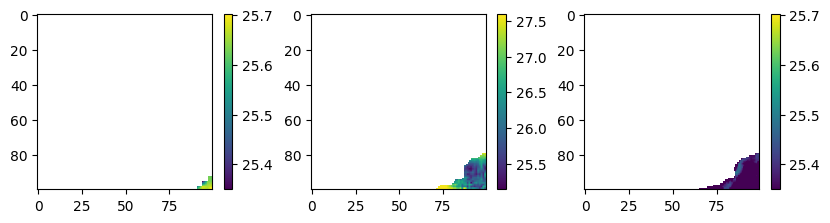

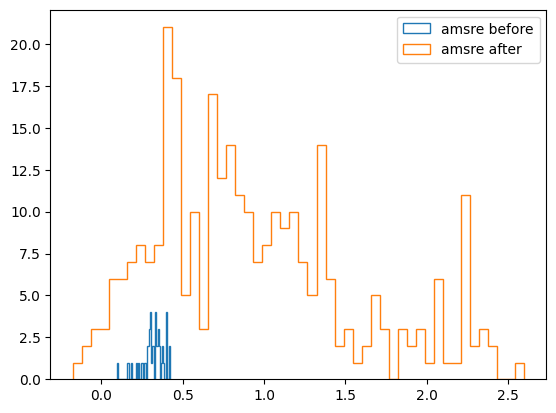

In [157]:
fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(2,3)


vmin = np.nanmin(ds.x0[0,0])
vmax = np.nanmax(ds.x0[0,0])

fig.add_subplot(gs[0,0])
plt.imshow(ds.x0[0,0],vmin=vmin,vmax=vmax)
# plt.colorbar(fraction=.02
plt.colorbar()

fig.add_subplot(gs[0,1])
plt.imshow(pred[0])
plt.colorbar()

fig.add_subplot(gs[0,2])
plt.imshow(ds.y0[0,0],vmin=vmin,vmax=vmax)
plt.colorbar()


plt.figure()
hist = ds.x0[0,0] - ds.y0[0,0]
hist = np.asarray(hist).reshape(-1)


hist1 = pred[0] - np.asarray(ds.y0[0,0])
hist1 = np.asarray(hist1).reshape(-1)

histplot = plt.hist(hist,bins=50,histtype='step');

plt.hist(hist1,bins=50,histtype='step');
plt.legend(['amsre before','amsre after',])
# hist1.shape

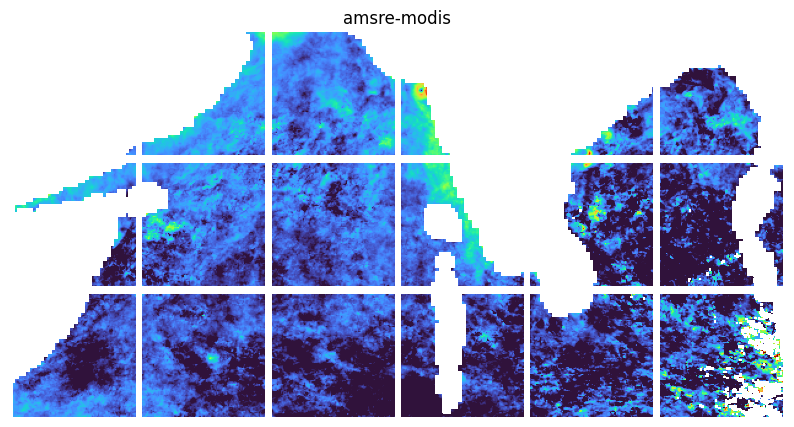

In [158]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'amsre-modis')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(ds.x0[idy,0] - ds.y0[idy,0],cmap='turbo',vmin=0,vmax=2)
    plt.axis('off')

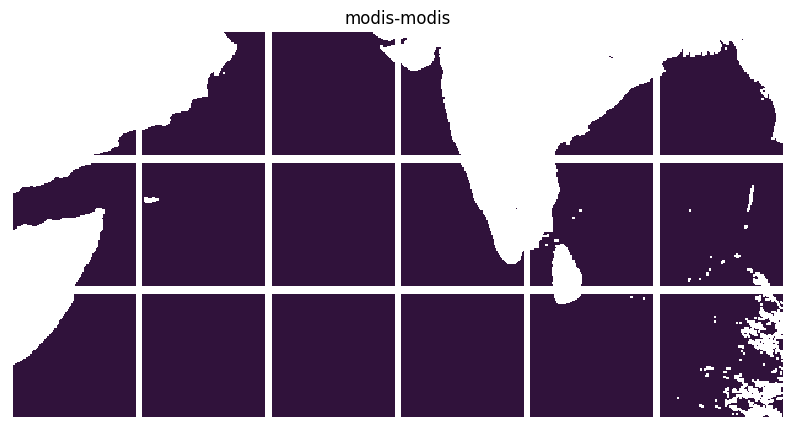

In [159]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'modis-modis')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(ds.y0[idy,0] - ds.y0[idy,0],cmap='turbo',vmin=0,vmax=2)
    plt.axis('off')

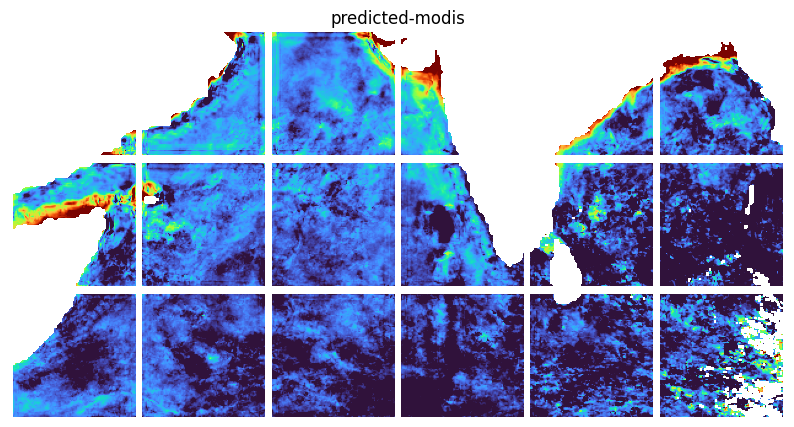

In [254]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'predicted-modis')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(pred[idy] - np.asarray(ds.y0[idy,0]),cmap='turbo',vmin=0,vmax=2)
    plt.axis('off')

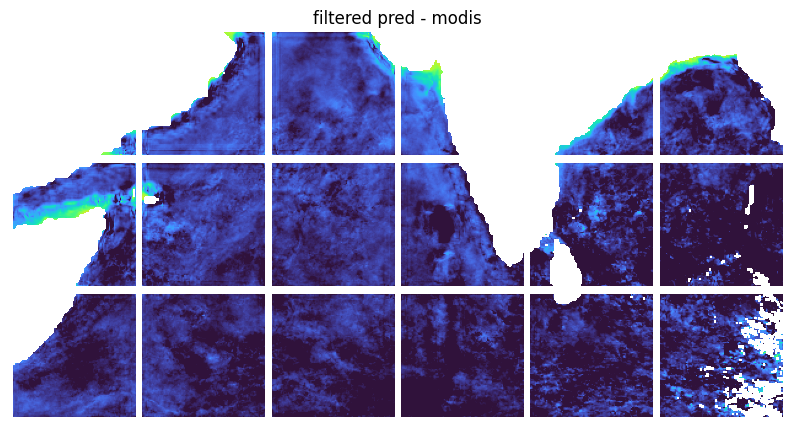

In [286]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'filtered pred - modis')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])    
    filter_coast = torch.from_numpy(np.where((pred[idy] - np.asarray(ds.y0[idy,0])) > 3, np.nan, (pred[idy] - np.asarray(ds.y0[idy,0]))))
    plt.imshow(filter_coast,cmap='turbo',vmin=0,vmax=5)
    plt.axis('off')


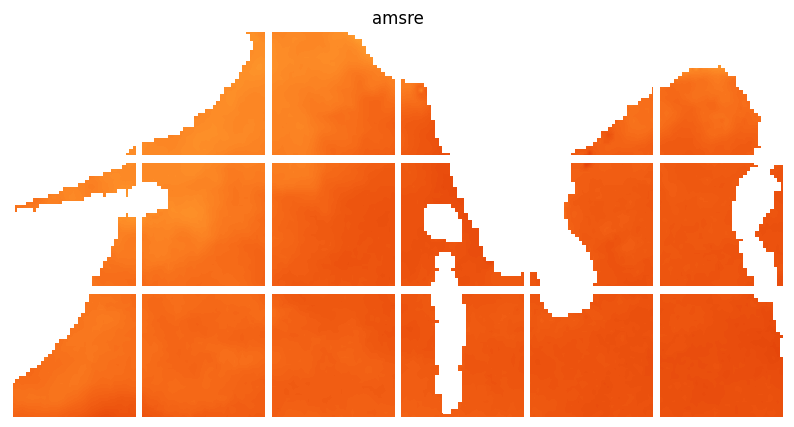

In [161]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title('amsre')
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(ds.x0[idy,0],cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')

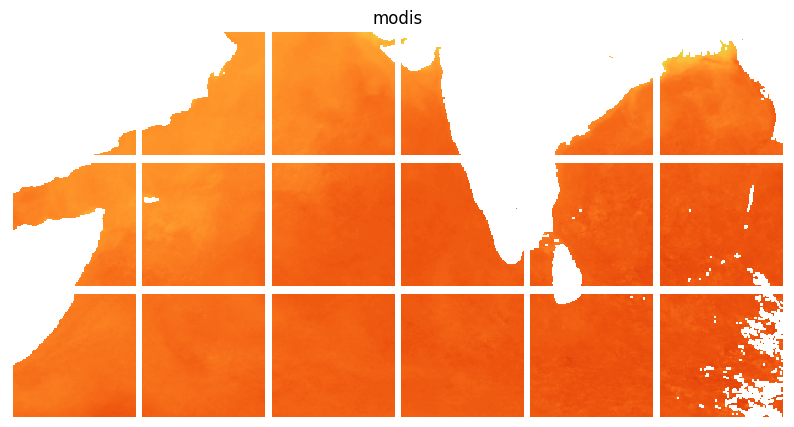

In [162]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title('modis')
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(ds.y0[idy,0],cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')

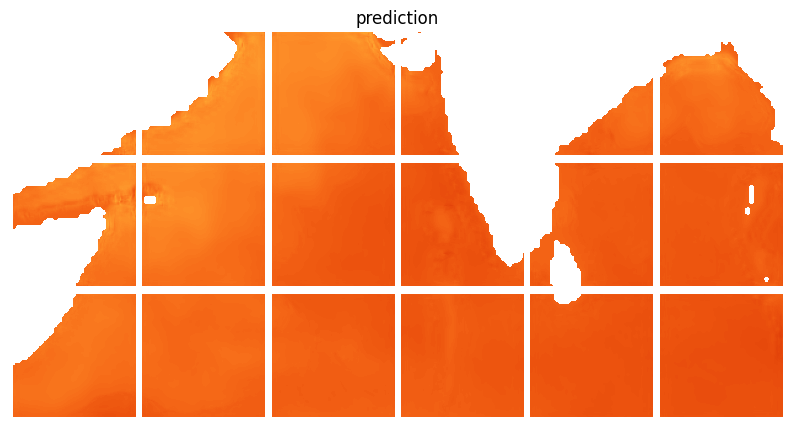

In [163]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'prediction')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(pred[idy],cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')

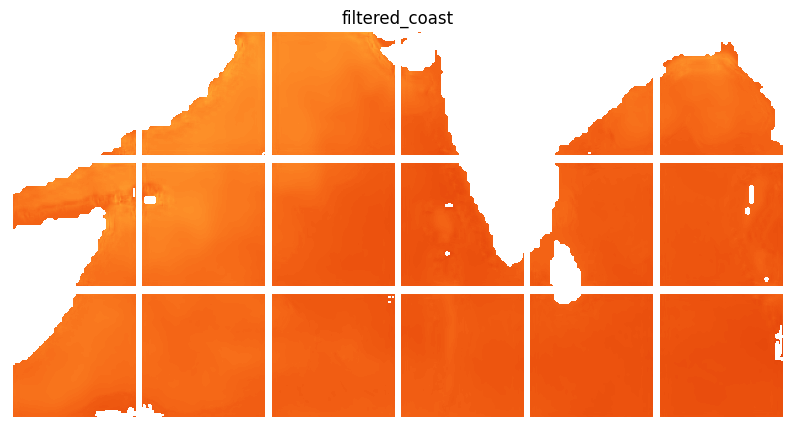

In [242]:
hei=3
wid=6

def conf99(x):
    mu = np.nanmean(x)
    sig = np.nanstd(x)
    return mu + (3*sig)

fig = plt.figure(figsize=(10,5))
plt.title(f'filtered_coast')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

filtered_coast = []
for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])    
    
    filter_coast = torch.from_numpy(np.where(np.abs(pred[idy]) > np.abs(conf99(pred[idy])),np.nan,pred[idy]))
    filtered_coast.append(filter_coast)                                      
                                             
                                             
    plt.imshow(filter_coast,cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')

In [96]:
argo_infer = torch.load('../data/patches/case_8_argo_2010_indian_night.pt')
argo_infer.shape

torch.Size([12, 18, 1, 100, 100])

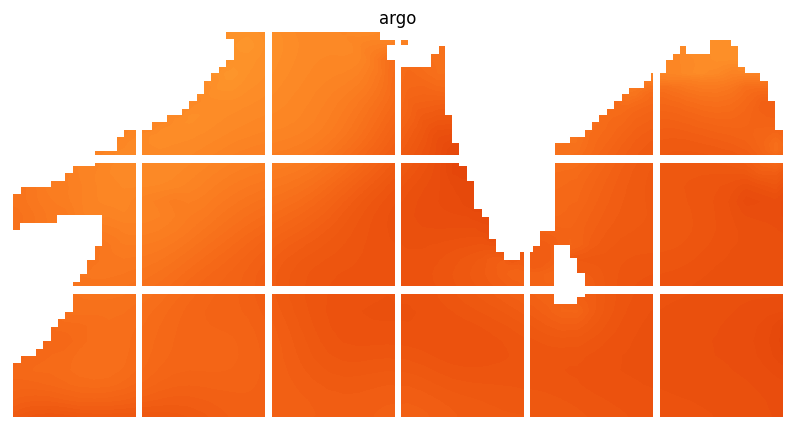

In [164]:
hei=3
wid=6

fig = plt.figure(figsize=(10,5))
plt.title(f'argo')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(argo_infer[-1][idy,0],cmap='turbo',vmin=0,vmax=35)
    plt.axis('off')

In [112]:
argo_infer.shape

torch.Size([12, 18, 1, 100, 100])

In [217]:
x = torch.tensor([1,2,np.nan])

y = torch.where(torch.isnan(x)==False,1,0)
z = torch.sum(y)

z.item()

2

In [257]:
def mse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    return mse, valcount

def rmse(x,y):
    e = y-x
    se = e**2
    
    valcount = torch.where(torch.isnan(se)==False,1,0)
    valcount = torch.sum(valcount)

    sse = np.nansum(se)
    mse = np.nanmean(sse)
    rmse = np.sqrt(mse)
    return rmse, valcount
        

panel = {'amsre':ds.x0,
         'modis':ds.y0,
         'pred':torch.from_numpy(np.asarray(pred)).unsqueeze(1),
         'optimal':filtered_coast
        }

avgrmse = []
vals_considered = []
for key,value in panel.items():
    rmseres = []
    vals = []
    for idj,j in enumerate(value):
        rmseresobj,valcount = rmse(argo_infer[-1][idj],j)
        vals.append(valcount)
        rmseres.append(rmseresobj)
    vals_considered.append(vals)
    rmseres = np.nanmean(rmseres)
    print(f'{key}\t\t{rmseres}')
    avgrmse.append(rmseres)

amsre		18.499069213867188
modis		40.33549499511719
pred		26.34215545654297
optimal		25.96295166015625


In [284]:
for idx,i in enumerate(vals_considered[0]):
    if idx == 0:
        print(f'# pixels in each patch available for comparison with argo\n\namsre\t\tmodis\t\tpred\t\toptim\n')
    print(f'{i}\t\t{vals_considered[1][idx]}\t\t{vals_considered[2][idx]}\t\t{vals_considered[3][idx]}')
print(f'\n')
print(f'{np.sum(vals_considered[0])}\t\t{np.sum(vals_considered[1])}\t\t{np.sum(vals_considered[2])}\t\t{np.sum(vals_considered[3])}\t\t total count of pixels inferred with')
print(f'{np.float16(avgrmse[0])}\t\t{np.float16(avgrmse[1])}\t{np.float16(avgrmse[2])}\t{np.float16(avgrmse[3])}\t average root mean squared errors')

# pixels in each patch available for comparison with argo

amsre		modis		pred		optim

45		325		294		294
4270		5831		5794		5717
9267		9826		9803		9803
1589		2822		2764		2764
1700		2666		2622		2621
4987		7109		7029		7029
2637		5565		5478		5473
9559		9972		9950		9950
10000		10000		10000		10000
4972		7272		7211		7200
6277		8054		7989		7989
7673		9875		9940		9940
7309		8175		8155		8023
10000		10000		10000		9908
10000		10000		10000		9997
8043		10000		10000		10000
9415		9841		9843		9843
9670		8865		10000		9918


117413		136198		136872		136469		 total count of pixels inferred with
18.5		40.34375	26.34375	25.96875	 average root mean squared errors


In [180]:
len(vals_considered)

3

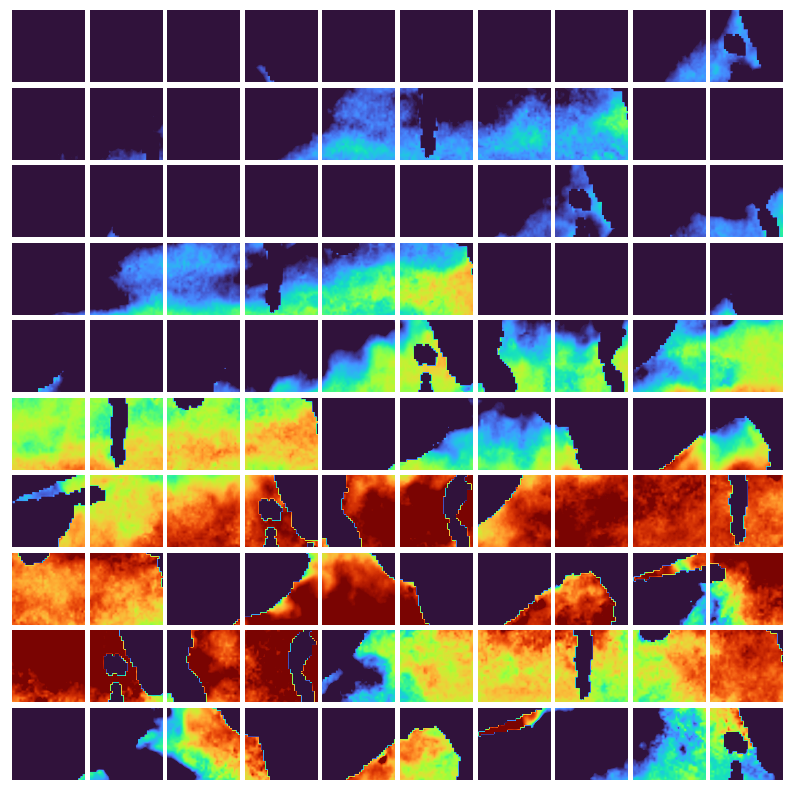

In [64]:
hei=10
wid=10

fig = plt.figure(figsize=(10,10))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(dset.x[idy,0],cmap='turbo',vmin=0,vmax=1.5)
    plt.axis('off')

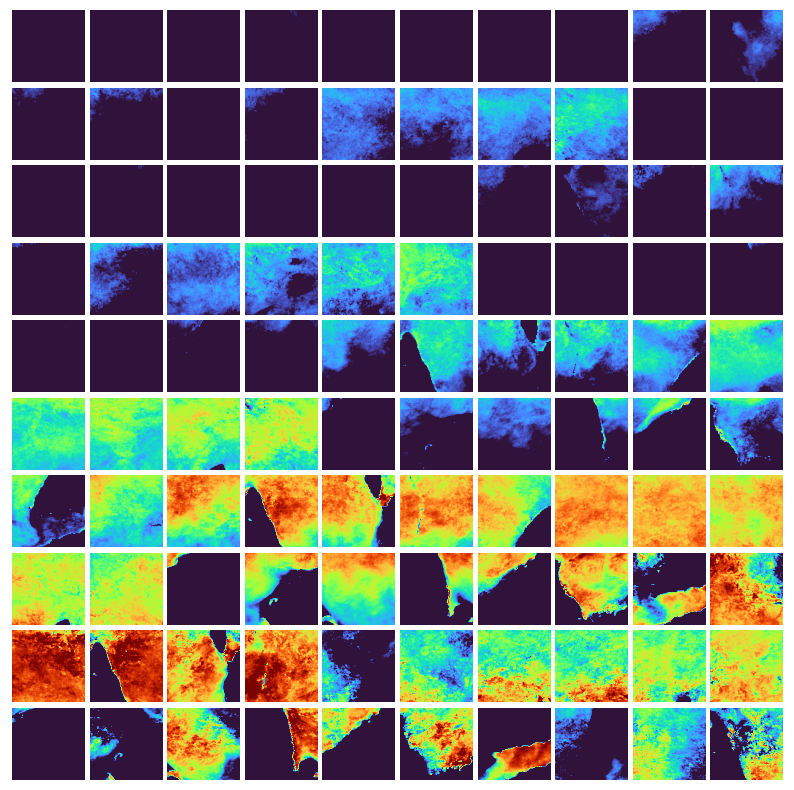

In [60]:
hei=10
wid=10

fig = plt.figure(figsize=(10,10))
# plt.title(f'{date}_{satnames[idx]}_{oc}_{satt}')
plt.axis('off')
gs = gridspec.GridSpec(hei,
                       wid,
                       hspace=.07,
                       wspace=.01,
                       width_ratios=list(itertools.repeat(.1,wid)),
                       height_ratios=list(itertools.repeat(.1,hei))
                       )

for idy,i in enumerate(itertools.product(range(hei),range(wid))):
    fig.add_subplot(gs[i[0],i[1]])
    plt.imshow(dset.y[idy,0],cmap='turbo',vmin=0,vmax=2)
    plt.axis('off')